# Desenvolvimento de Modelo para Previsão de Valor de Aluguel

Renato Barros

## Case

A Sexto Andar, empresa do ramo imobiliário, busca otimizar o processo de
definição de preço de aluguel para imóveis em sua plataforma. O objetivo
deste projeto é construir um modelo de machine learning capaz de prever
o valor ideal de aluguel, levando em consideração as características do
imóvel e informações relevantes do mercado imobiliário.

Os dados para treinamento do modelo serão obtidos a partir do banco de
dados da Sexto Andar, compreendendo informações sobre cada imóvel
cadastrado na plataforma. As variáveis disponíveis são:

Variáveis Descritivas:

-   Cidade: Cidade onde o imóvel está localizado (texto).
-   Área: Área do imóvel em metros quadrados (numérica).
-   Quartos: Número de quartos (numérica).
-   Banheiros: Número de banheiros (numérica).
-   Garagem: Número de vagas na garagem (numérica).
-   Andar: Andar do imóvel (numérica).
-   Animal: Se permite animais de estimação (booleano - Sim/Não).
-   Mobiliado: Se o imóvel está mobiliado (booleano - Sim/Não).

Variáveis Numéricas:

-   Condomínio: Valor da taxa de condomínio em reais (numérica).
-   Valor IPTU: Valor do IPTU em reais (numérica).
-   Valor Seguro: Valor do seguro de incêndio em reais (numérica).
-   Variável Alvo:
-   Valor Aluguel: Valor do aluguel em reais (numérica).

## Parte 0: Importações, Configurações e Funções

### Seção 0.1 Importação de bibliotecas

Nesta seção, importamos as bibliotecas necessárias para o nosso pipeline
de aprendizado de máquina. Essas bibliotecas fornecem funcionalidades
para análise de dados, visualização, pré-processamento e modelagem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

import warnings as wrn
#wrn.filterwarnings("ignore", category=FutureWarning)
#wrn.filterwarnings("ignore", category=DeprecationWarning)
wrn.filterwarnings("ignore")

### Seção 0.2 Configurações e Parâmetros

Aqui, definimos algumas configurações globais e parâmetros que serão
usados em todo o pipeline. Essas configurações incluem o número de folds
para validação cruzada, o uso de valores logarítmicos, a variável alvo e
o limite de correlação.

In [2]:
nr_cv = 5
use_logvals = 1
target = 'aluguel'
min_val_corr = 0.4
drop_similar = 1

### Seção 0.3 Funções úteis

Para tornar nosso código mais organizado e reutilizável, definimos
algumas funções auxiliares. Essas funções encapsulam tarefas comuns,
como obter a melhor pontuação de uma pesquisa em grade e imprimir
colunas com alta correlação.

In [3]:
def get_best_score(grid):
    # Esta função extrai e imprime a melhor pontuação, melhores parâmetros e melhor estimador de uma pesquisa em grade.
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)

    return best_score

In [4]:
def print_cols_large_corr(df, nr_c, targ) :
    # Esta função imprime as colunas que têm uma correlação com a variável alvo acima de um limite especificado.
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

### Seção 0.4 Carregamento de dados

Nesta etapa, carregamos o conjunto de dados do arquivo CSV usando a
biblioteca Pandas. O conjunto de dados contém informações sobre
aluguéis.

In [5]:
df = pd.read_csv("aluguel.csv", sep = ";")

### Seção 0.5 Visualização inicial dos dados

Para ter uma ideia inicial dos dados, visualizamos as primeiras e
últimas linhas, informações resumidas e estatísticas descritivas.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10685 entries, 0 to 10684
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cidade            10685 non-null  object
 1   area              10685 non-null  int64 
 2   quartos           10685 non-null  int64 
 3   banheiros         10685 non-null  int64 
 4   vagas_garagem     10685 non-null  int64 
 5   andar             10685 non-null  int64 
 6   aceita_animal     10685 non-null  int64 
 7   mobiliaria        10685 non-null  int64 
 8   valor_condominio  10685 non-null  int64 
 9   valor_aluguel     10685 non-null  int64 
 10  valor_iptu        10685 non-null  int64 
 11  valor_seguro      10685 non-null  int64 
 12  valor_total       10685 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.1+ MB

In [7]:
df.head()

In [8]:
df.tail()

In [9]:
df.describe()

In [10]:
df.shape

(10685, 13)

In [11]:
df.columns

Index(['cidade', 'area', 'quartos', 'banheiros', 'vagas_garagem', 'andar',
       'aceita_animal', 'mobiliaria', 'valor_condominio', 'valor_aluguel',
       'valor_iptu', 'valor_seguro', 'valor_total'],
      dtype='object')

### Seção 0.6 Renomeando colunas

Para facilitar a análise, renomeamos algumas colunas com nomes mais
descritivos.

In [12]:
df.rename(columns = {"vagas_garagem" : "garagem", "aceita_animal" : "pet",
                    "mobiliaria" : "mobilia", "valor_condominio" : "condominio",
                    "valor_aluguel" : "aluguel", "valor_iptu" : "iptu",
                    "valor_seguro" : "seguro", "valor_total" : "total"},
                    inplace = True)

In [13]:
df.head()

### Seção 0.7 Divisão treino-teste

Dividimos o conjunto de dados em conjuntos de treinamento e teste para
avaliar o desempenho do modelo em dados não vistos.

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

## Parte 1: Análise Exploratória de Dados (EDA)

Nesta parte, realizamos uma análise exploratória de dados (EDA) para
obter insights sobre os dados e preparar os dados para a modelagem.

### Seção 1.1 Visão geral das features e relação com a variável alvo

#### Subseção 1.1.1 Shape, info, head e describe

Verificamos o formato, as informações, as primeiras linhas e as
estatísticas descritivas dos conjuntos de dados de treinamento e teste.

In [15]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(7479, 13)
**************************************************
(3206, 13)

In [16]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7479 entries, 6705 to 7270
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cidade      7479 non-null   object
 1   area        7479 non-null   int64 
 2   quartos     7479 non-null   int64 
 3   banheiros   7479 non-null   int64 
 4   garagem     7479 non-null   int64 
 5   andar       7479 non-null   int64 
 6   pet         7479 non-null   int64 
 7   mobilia     7479 non-null   int64 
 8   condominio  7479 non-null   int64 
 9   aluguel     7479 non-null   int64 
 10  iptu        7479 non-null   int64 
 11  seguro      7479 non-null   int64 
 12  total       7479 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 818.0+ KB
None
**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 3206 entries, 6343 to 7919
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 

In [17]:
df_train.head()

In [18]:
df_train.describe()

In [19]:
df_test.head()

In [20]:
df_test.describe()

#### Subseção 1.1.2 A variável alvo: Distribuição do Aluguel

Examinamos a distribuição da variável alvo, ‘aluguel’, usando um
histograma e calculando a assimetria e curtose.

Skewness: 1.691682
Kurtosis: 2.794266

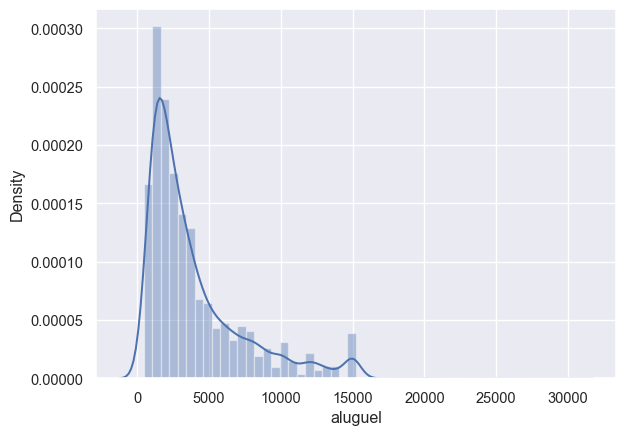

In [21]:
sns.distplot(df_train['aluguel']);
#skewness and kurtosis
print("Skewness: %f" % df_train['aluguel'].skew())
print("Kurtosis: %f" % df_train['aluguel'].kurt())

#### Subseção 1.1.3 Transformação logarítmica da variável alvo

Para lidar com a assimetria, aplicamos uma transformação logarítmica à
variável alvo e examinamos a distribuição resultante.

Skewness: 0.224083
Kurtosis: -0.703403

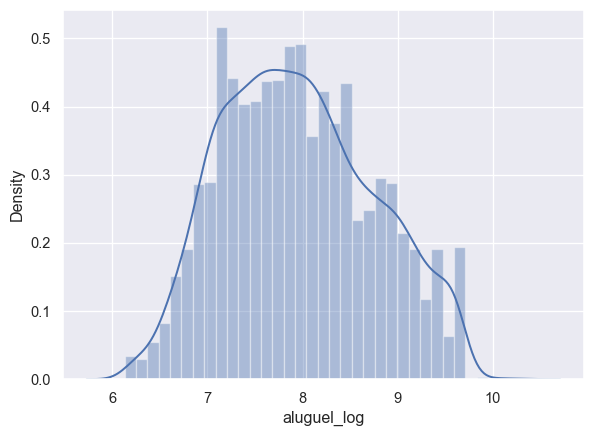

In [22]:
df_train['aluguel_log'] = np.log(df_train['aluguel'])

sns.distplot(df_train['aluguel_log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['aluguel_log'].skew())
print("Kurtosis: %f" % df_train['aluguel_log'].kurt())
# dropping old column
df_train.drop('aluguel', axis= 1, inplace=True)

In [23]:
target = 'aluguel_log'

#### Subseção 1.1.4 Features numéricas e categóricas

Identificamos as features numéricas e categóricas no conjunto de dados.

In [24]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  12
Number of Categorical features:  1

In [25]:
print(df_train[numerical_feats].columns)
print("*"*100)
print(df_train[categorical_feats].columns)

Index(['area', 'quartos', 'banheiros', 'garagem', 'andar', 'pet', 'mobilia',
       'condominio', 'iptu', 'seguro', 'total', 'aluguel_log'],
      dtype='object')
****************************************************************************************************
Index(['cidade'], dtype='object')

In [26]:
df_train[numerical_feats].head()

In [27]:
df_train[categorical_feats].head()

#### Subseção 1.1.5 Lista de features com valores ausentes

Verificamos os valores ausentes no conjunto de dados e exibimos as
features com valores ausentes em ordem decrescente.

In [28]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [29]:
df_train.isnull().sum().sum()

0

In [30]:
df_test.isnull().sum().sum()

0

#### Subseção 1.1.6 Transformação logarítmica de features numéricas

Para lidar com a assimetria em features numéricas, aplicamos uma
transformação logarítmica e examinamos as distribuições resultantes.

In [31]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

area            Skewness: 63.59     Kurtosis: 4447.15
quartos         Skewness: 00.71     Kurtosis: 001.60
banheiros       Skewness: 01.20     Kurtosis: 001.10
garagem         Skewness: 01.49     Kurtosis: 002.78
andar           Skewness: 01.47     Kurtosis: 002.92
pet             Skewness: -1.32     Kurtosis: -00.27
mobilia         Skewness: 01.21     Kurtosis: -00.54
condominio      Skewness: 02.79     Kurtosis: 014.56
iptu            Skewness: 04.99     Kurtosis: 046.41
seguro          Skewness: 01.79     Kurtosis: 003.48
total           Skewness: 01.67     Kurtosis: 002.81
aluguel_log     Skewness: 00.22     Kurtosis: -00.70

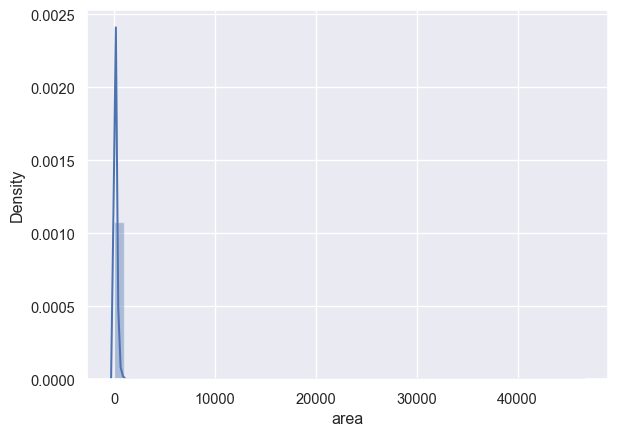

Skewness: 63.585521
Kurtosis: 4447.148046

In [32]:
sns.distplot(df_train['area']);
plt.show()
#skewness and kurtosis
print("Skewness: %f" % df_train['area'].skew())
print("Kurtosis: %f" % df_train['area'].kurt())

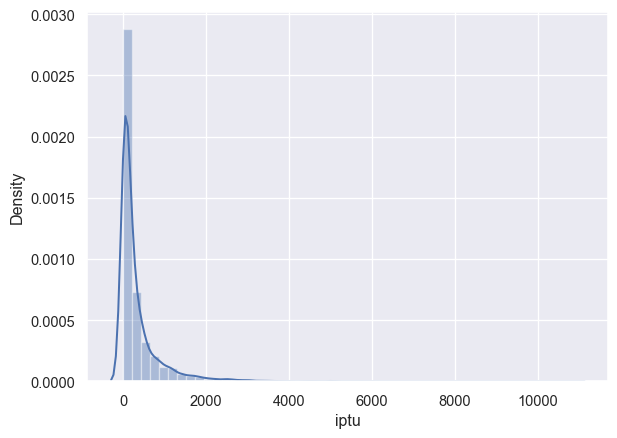

Skewness: 4.992678
Kurtosis: 46.413505

In [33]:
sns.distplot(df_train['iptu']);
plt.show()
#skewness and kurtosis
print("Skewness: %f" % df_train['iptu'].skew())
print("Kurtosis: %f" % df_train['iptu'].kurt())

Skewness: 2.792669
Kurtosis: 14.559081

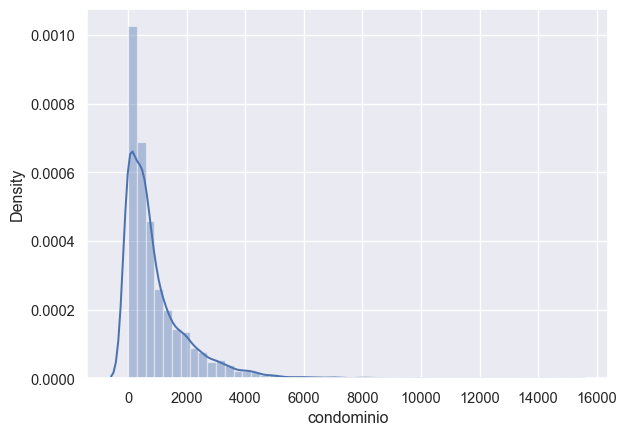

In [34]:
sns.distplot(df_train['condominio']);
#skewness and kurtosis
print("Skewness: %f" % df_train['condominio'].skew())
print("Kurtosis: %f" % df_train['condominio'].kurt())

In [35]:
from sklearn.preprocessing import PowerTransformer

# Crie uma instância do PowerTransformer com o método Yeo-Johnson
transformer = PowerTransformer(method='yeo-johnson')

for df in [df_train, df_test]:
    for col in ['area', 'iptu', 'condominio']:
        # 1. Lida com zero adicionando 1
        df[col] = df[col] + 1
        # 2. Ajusta e aplica a transformação de Yeo-Johnson
        #     (Note que estamos chamando fit_transform no objeto 'transformer')
        df[f'{col}_log'] = transformer.fit_transform(df[[col]]) 

# Seleciona apenas as colunas numéricas, incluindo as transformadas
df_numeric = df_train.select_dtypes(include=['number'])

numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: 0.021841
Kurtosis: -0.444340

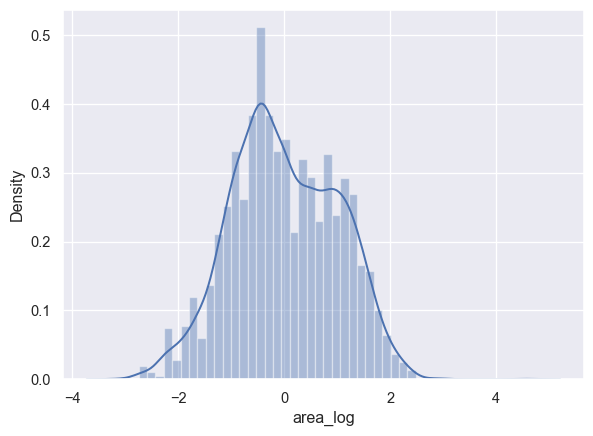

In [36]:
sns.distplot(df_train['area_log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['area_log'].skew())
print("Kurtosis: %f" % df_train['area_log'].kurt())

Skewness: -0.064586
Kurtosis: -0.454920

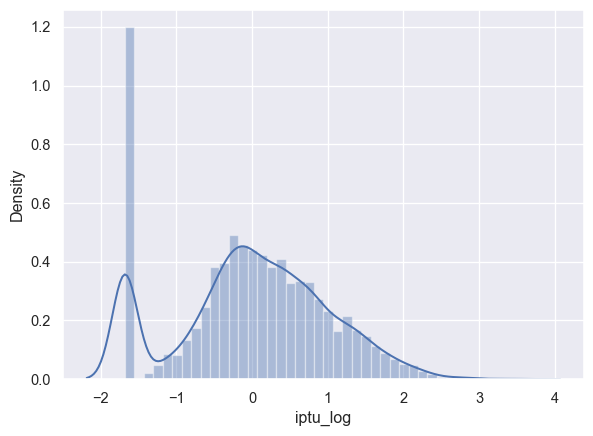

In [37]:
sns.distplot(df_train['iptu_log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['iptu_log'].skew())
print("Kurtosis: %f" % df_train['iptu_log'].kurt())

Skewness: -0.302038
Kurtosis: -0.721538

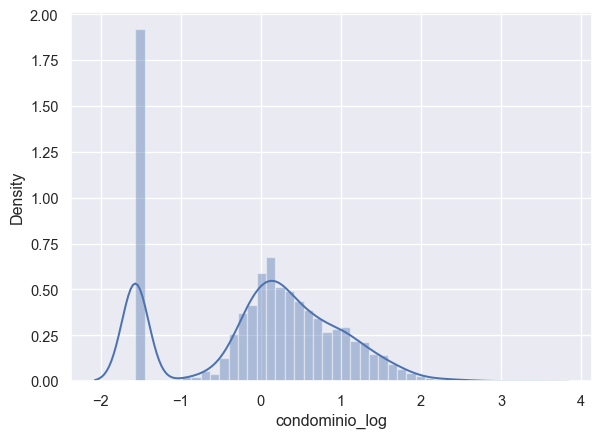

In [38]:
sns.distplot(df_train['condominio_log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['condominio_log'].skew())
print("Kurtosis: %f" % df_train['condominio_log'].kurt())

#### Subseção 1.1.7 Relação das features com a variável alvo (aluguel_log)

Investigamos a relação entre as features numéricas e a variável alvo
usando gráficos de dispersão e calculando a correlação.

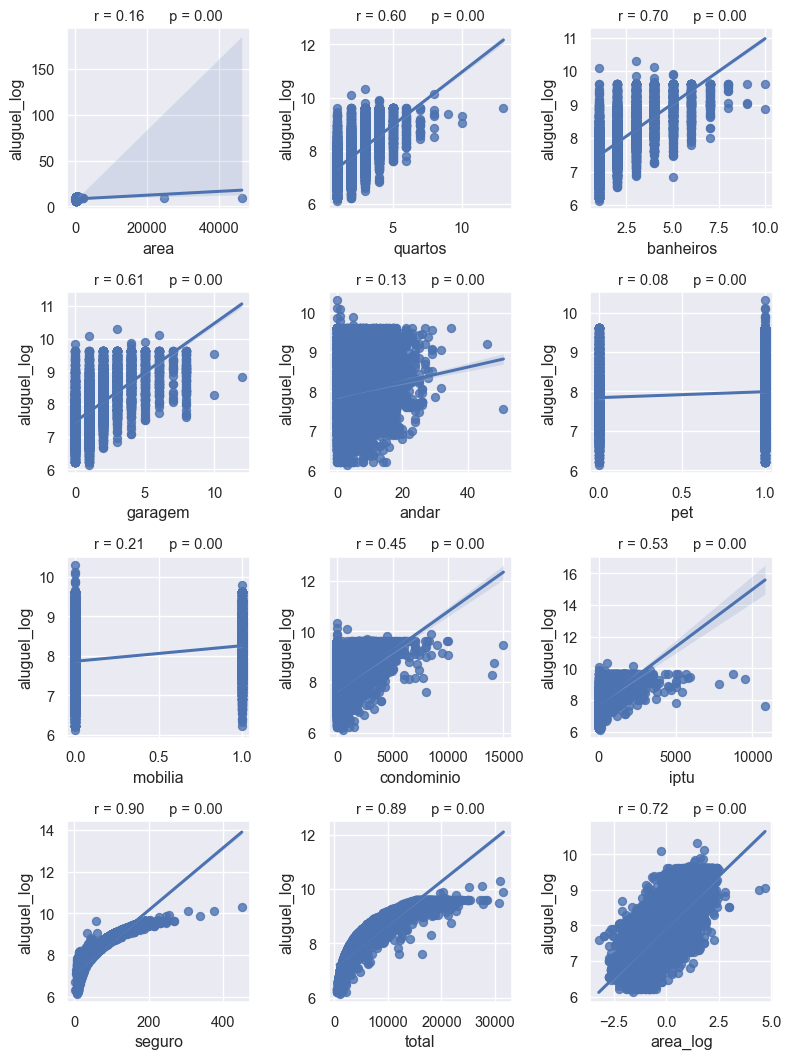

In [39]:
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*2.8,nr_rows*2.8))

li_num_feats = list(numerical_feats)
li_not_plot = ['aluguel_log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(data=df_train, x=li_plot_num_feats[i], y=target, ax=axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

#### Subseção 1.1.8 Outliers

Nesta etapa, identificamos e tratamos os outliers nas features numéricas
usando winsorização. No entanto, a winsorização não foi aplicada neste
projeto pois causou erro no cálculo da correlação.

In [40]:
#from scipy.stats.mstats import winsorize
# Define os percentis para winsorização
#percentil_inferior = 0.05
#percentil_superior = 0.95

# Aplica a winsorização às colunas transformadas pelo logaritmo
#for df in [df_train, df_test]:
#    for col in ['area_log', 'iptu_log', 'condominio_log']:
#        df[col] = winsorize(df[col], limits=[percentil_inferior, percentil_superior])

#### Subseção 1.1.9 Encontrar colunas com forte correlação com a variável alvo

Calculamos a correlação entre as features numéricas e a variável alvo e
selecionamos as features com alta correlação.

In [41]:
df_numeric = df_train.drop(['cidade', 'area', 'iptu', 'condominio'], axis=1)

In [42]:
corr_abs =  df_numeric.corr().abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [43]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

aluguel_log       1.000000
seguro            0.901430
total             0.892131
area_log          0.721076
banheiros         0.695827
iptu_log          0.613303
garagem           0.606410
quartos           0.596910
condominio_log    0.238470
mobilia           0.213299
andar             0.127330
pet               0.079466
Name: aluguel_log, dtype: float64
******************************
List of numerical features with r above min_val_corr :
['aluguel_log', 'seguro', 'total', 'area_log', 'banheiros', 'iptu_log', 'garagem', 'quartos']
******************************
List of numerical features with r below min_val_corr :
['condominio_log', 'mobilia', 'andar', 'pet']

In [44]:
df_corr = df_train.drop(['cidade', 'area', 'iptu', 'condominio',
                        'condominio_log', 'mobilia', 'andar',
                        'pet'], axis=1)

#### Subseção 1.1.10 Lista de features categóricas e seus valores únicos

Examinamos as features categóricas e seus valores únicos.

In [45]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)

cidade
São Paulo         4125
Rio de Janeiro    1045
Belo Horizonte     887
Porto Alegre       819
Campinas           603
Name: count, dtype: int64
##################################################

#### Subseção 1.1.11 Relação com a variável alvo para todas as features categóricas

Investigamos a relação entre as features categóricas e a variável alvo
usando boxplots.

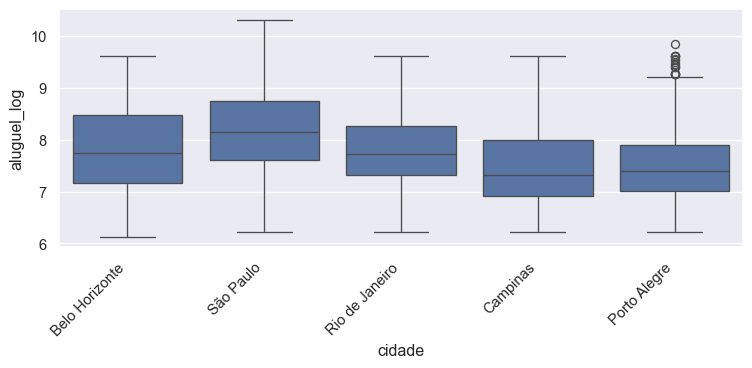

In [46]:
# Definindo a feature categórica específica
# Ajustando o layout para uma única linha (como só temos uma feature agora)
plt.figure(figsize=(8, 4)) # Largura maior para acomodar todas as cidades

sns.boxplot(x='cidade', y=target, data=df_train) 
plt.xticks(rotation=45, ha='right') # Rotaciona os nomes das cidades se necessário
plt.tight_layout()  
plt.show()

In [47]:
for catg in cols_abv_corr_limit :
    g = df_train.groupby(catg)[target].mean()
    print(g)

aluguel_log
6.131226      6.131226
6.214608      6.214608
6.220590      6.220590
6.224558      6.224558
6.234411      6.234411
               ...    
9.878170      9.878170
9.903488      9.903488
10.085809    10.085809
10.126631    10.126631
10.308953    10.308953
Name: aluguel_log, Length: 989, dtype: float64
seguro
3       6.501621
5       7.171753
6       7.217619
7       6.528441
8       6.660192
         ...    
267     9.615805
305    10.085809
338     9.852194
376    10.126631
451    10.308953
Name: aluguel_log, Length: 208, dtype: float64
total
507       6.214608
508       6.214608
509       6.214608
545       6.214608
550       6.291569
           ...    
28310     9.615805
28490     9.615805
30660     9.472705
31010    10.308953
31580     9.878170
Name: aluguel_log, Length: 4653, dtype: float64
area_log
-3.226355    7.600902
-2.956077    7.696213
-2.725651    6.925197
-2.622238    6.910294
-2.525450    7.764477
               ...   
 2.507725    9.546813
 2.804143    8.887590

#### Subseção 1.1.12 Codificação de features categóricas

Para lidar com a feature categórica ‘cidade’, usamos a codificação
TargetEncoder para criar uma representação numérica.

In [48]:
import category_encoders as ce

# Instancia o encoder com suavização
encoder = ce.TargetEncoder(cols=['cidade'],  # Substitua 'cidade' pela sua coluna
                          smoothing=10)  # Ajuste o parâmetro de suavização

# Ajusta o encoder aos dados de TREINO e transforma ambos
df_train['cidade_mean_enc'] = encoder.fit_transform(df_train['cidade'], 
                                                    df_train[target])
df_test['cidade_mean_enc'] = encoder.transform(df_test['cidade'])

In [49]:
# Agora você tem a nova feature 'cidade_mean_enc' nos seus DataFrames
print(df_train.head())

              cidade  area  quartos  banheiros  garagem  andar  pet  mobilia  \
6705  Belo Horizonte    61        2          1        1     12    0        0   
2689       São Paulo    51        1          1        0      4    1        0   
6114  Rio de Janeiro   101        3          2        1      7    0        0   
5094       São Paulo   179        3          4        2      4    0        0   
749        São Paulo   173        3          4        3      5    1        0   

      condominio  iptu  seguro  total  aluguel_log  area_log  iptu_log  \
6705         286    21      14   1319     6.907755 -0.639830 -0.837288   
2689         101     1      14   1214     7.003065 -0.894058 -1.682312   
6114        1101   191      39   4329     8.006368  0.035174  0.250334   
5094        2451   835     127  13410     9.210340  0.730933  1.227858   
749         1651   901     115  11670     9.104980  0.691486  1.284679   

      condominio_log  cidade_mean_enc  
6705       -0.226184         7.862

In [50]:
print(df_test.head())

              cidade  area  quartos  banheiros  garagem  andar  pet  mobilia  \
6343  Rio de Janeiro   126        3          2        1      5    1        1   
668   Belo Horizonte    81        3          3        1      3    1        0   
1780       São Paulo   351        2          4        8      0    0        0   
2930       São Paulo    78        3          3        2      0    1        0   
1523       São Paulo   281        4          4        4      6    0        1   

      condominio  aluguel  iptu  seguro  total  area_log  iptu_log  \
6343        1461     3500   296      46   5301  0.355164  0.560497   
668          561     1501     1      20   2081 -0.215550 -1.666373   
1780           1     3300   451      50   3800  1.521160  0.826593   
2930         224     2400    71      37   2730 -0.266310 -0.232166   
1523        3201     6000   101      77   9377  1.285662 -0.051385   

      condominio_log  cidade_mean_enc  
6343        0.836909         7.801434  
668         0.1778

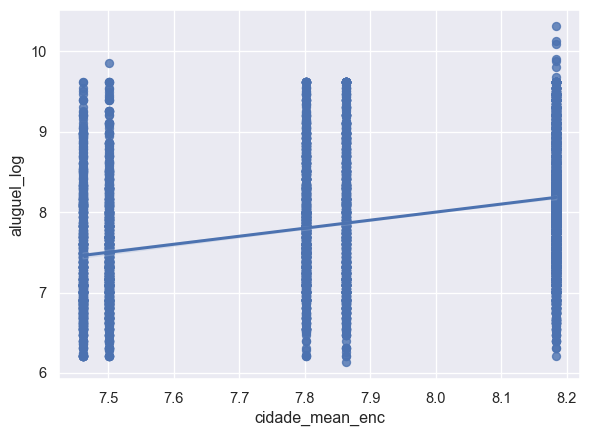

In [51]:
sns.regplot(data=df_train, x='cidade_mean_enc', y=target)
plt.show()

In [52]:
df_numeric = df_train.drop(['cidade', 'area', 'iptu', 'condominio'], axis=1)

corr_abs =  df_numeric.corr().abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

aluguel_log        1.000000
seguro             0.901430
total              0.892131
area_log           0.721076
banheiros          0.695827
iptu_log           0.613303
garagem            0.606410
quartos            0.596910
cidade_mean_enc    0.346962
condominio_log     0.238470
mobilia            0.213299
andar              0.127330
pet                0.079466
Name: aluguel_log, dtype: float64
******************************
List of numerical features with r above min_val_corr :
['aluguel_log', 'seguro', 'total', 'area_log', 'banheiros', 'iptu_log', 'garagem', 'quartos']
******************************
List of numerical features with r below min_val_corr :
['cidade_mean_enc', 'condominio_log', 'mobilia', 'andar', 'pet']

#### Subseção 1.1.13 Matriz de correlação

Criamos uma matriz de correlação para visualizar a correlação entre as
features numéricas.

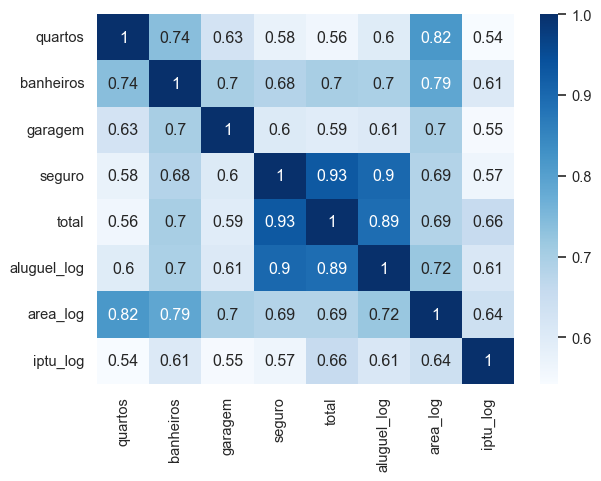

In [53]:
sns.heatmap(df_corr.corr(), annot = True, cmap='Blues');

#### Subseção 1.1.14 Remoção de features com baixa correlação

Removemos as features com baixa correlação com a variável alvo.

In [54]:
# Colunas adicionais para remover
cols_to_remove = ['cidade', 'condominio', 'iptu', 'area', "seguro"]

# Removendo as colunas
for df in [df_train, df_test]:
    df.drop(cols_bel_corr_limit, axis=1, inplace=True)
    df.drop(cols_to_remove, axis=1, inplace=True)

# Verificando as colunas restantes (opcional)
print(df_train.columns)

Index(['quartos', 'banheiros', 'garagem', 'total', 'aluguel_log', 'area_log',
       'iptu_log'],
      dtype='object')

In [55]:
print(df_test.columns)

Index(['quartos', 'banheiros', 'garagem', 'aluguel', 'total', 'area_log',
       'iptu_log'],
      dtype='object')

In [56]:
cols = list(df_train.columns)
print(cols)

['quartos', 'banheiros', 'garagem', 'total', 'aluguel_log', 'area_log', 'iptu_log']

In [57]:
feats = cols.copy()
feats.remove('aluguel_log')

print(feats)

['quartos', 'banheiros', 'garagem', 'total', 'area_log', 'iptu_log']

#### Subseção 1.1.15 Criando conjuntos de dados para algoritmos de ML

Criamos conjuntos de dados finais para treinamento e teste de modelos de
aprendizado de máquina.

In [58]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

## Parte 2: Pré-processamento de dados

Nesta parte, pré-processamos os dados para prepará-los para os
algoritmos de aprendizado de máquina.

#### Subseção 2.1 StandardScaler

Aplicamos o StandardScaler para dimensionar as features numéricas.

In [59]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [60]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

#### Subseção 2.2 Criando conjuntos de dados para algoritmos de ML

Criamos conjuntos de dados finais para treinamento e teste de modelos de
aprendizado de máquina.

In [61]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7479 entries, 6705 to 7270
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   quartos    7479 non-null   int64  
 1   banheiros  7479 non-null   int64  
 2   garagem    7479 non-null   int64  
 3   total      7479 non-null   int64  
 4   area_log   7479 non-null   float64
 5   iptu_log   7479 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 409.0 KB
<class 'pandas.core.frame.DataFrame'>
Index: 3206 entries, 6343 to 7919
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   quartos    3206 non-null   int64  
 1   banheiros  3206 non-null   int64  
 2   garagem    3206 non-null   int64  
 3   total      3206 non-null   int64  
 4   area_log   3206 non-null   float64
 5   iptu_log   3206 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 175.3 KB

In [62]:
X.head()

In [63]:
X_sc.head()

In [64]:
X_test.head()

## Parte 3: Modelagem e Avaliação

Nesta parte, treinamos e avaliamos diferentes modelos de aprendizado de
máquina para prever a variável alvo.

#### Subseção 3.1 Ajuste e seleção de modelos com GridSearchCV

Usamos o GridSearchCV para ajustar hiperparâmetros e selecionar o melhor
modelo para cada tipo de algoritmo.

In [65]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

#### Subseção 3.2 Regressão Linear

Treinamos um modelo de regressão linear e avaliamos seu desempenho.

In [66]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept': [True, False], 'copy_X': [True, False]} 
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.3370044301629265
{'copy_X': True, 'fit_intercept': True}
LinearRegression()

In [67]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept': [True, False], 'copy_X': [True, False]} 
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.3370044301629265
{'copy_X': True, 'fit_intercept': True}
LinearRegression()

In [68]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [69]:
sub_linreg = pd.DataFrame()
sub_linreg['aluguel'] = pred_linreg_all
#sub_linreg.to_csv('linreg.csv',index=False)

#### Subseção 3.3 Ridge

Treinamos um modelo Ridge e avaliamos seu desempenho.

In [70]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'tol':[1e-06,5e-06,1e-05, 5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.33700433335108954
{'alpha': 1, 'tol': 1e-06}
Ridge(alpha=1, tol=1e-06)

In [71]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.33700370251094675
{'alpha': 1, 'tol': 1e-06}
Ridge(alpha=1, tol=1e-06)

In [72]:
pred_ridge_all = grid_ridge.predict(X_test)

#### Subseção 3.4 Lasso

Treinamos um modelo Lasso e avaliamos seu desempenho.

In [73]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.3370138874429869
{'alpha': 0.001, 'tol': 1e-05}
Lasso(alpha=0.001, tol=1e-05)

In [74]:
pred_lasso = grid_lasso.predict(X_test)

#### Subseção 3.5 ElasticNet

Treinamos um modelo ElasticNet e avaliamos seu desempenho.

In [75]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.3439411382921002
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.05, 'max_iter': 1000000, 'tol': 0.0001}
ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=1000000)

In [76]:
pred_enet = grid_enet.predict(X_test_sc)

#### Subseção 3.6 SGDRegressor

Treinamos um modelo SGDRegressor e avaliamos seu desempenho.

In [77]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]}
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_sgd.fit(X_sc, y_sc)

sc_sgd = get_best_score(grid_sgd)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.33748029647950956
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)

In [78]:
pred_sgd = grid_sgd.predict(X_test_sc)

#### Subseção 3.7 DecisionTreeRegressor

Treinamos um modelo DecisionTreeRegressor e avaliamos seu desempenho.

In [79]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.18252386807482027
{'max_depth': 8, 'max_features': 11, 'max_leaf_nodes': None, 'min_samples_split': 25, 'random_state': 5}
DecisionTreeRegressor(max_depth=8, max_features=11, min_samples_split=25,
                      random_state=5)

In [80]:
pred_dtree = grid_dtree.predict(X_test)

In [81]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['aluguel'] = dtree_pred
#sub_dtree.to_csv('dtreeregr.csv',index=False)

#### Subseção 3.8 RandomForestRegressor

Treinamos um modelo RandomForestRegressor e avaliamos seu desempenho.

In [82]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.16368287730973774
{'min_samples_split': 10, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=10, random_state=5)

In [83]:
pred_rf = grid_rf.predict(X_test)

In [84]:
sub_rf = pd.DataFrame()
sub_rf['aluguel'] = pred_rf 

if use_logvals == 1:
    sub_rf['aluguel'] = np.exp(sub_rf['aluguel']) 

sub_rf.to_csv('rf.csv',index=False)

In [85]:
sub_rf.head(10)

#### Subseção 3.9 KNeighborsRegressor

Treinamos um modelo KNeighborsRegressor e avaliamos seu desempenho.

In [86]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
0.2092404089438517
{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, weights='distance')

In [87]:
pred_knn = grid_knn.predict(X_test_sc)

In [88]:
sub_knn = pd.DataFrame()
sub_knn['aluguel'] = pred_knn

if use_logvals == 1:
    sub_knn['aluguel'] = np.exp(sub_knn['aluguel']) 

sub_knn.to_csv('knn.csv',index=False)

In [89]:
sub_knn.head(10)

#### Subseção 3.10 GaussianProcessRegressor

Treinamos um modelo GaussianProcessRegressor e avaliamos seu desempenho.

In [90]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=nr_cv, verbose=1, scoring = score_calc)
grid_gpr.fit(X_sc, y_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.3370039819124685
{'kernel': DotProduct(sigma_0=1), 'normalize_y': True}
GaussianProcessRegressor(alpha=5e-09, kernel=DotProduct(sigma_0=1),
                         normalize_y=True, random_state=5)

In [91]:
pred_gpr = grid_gpr.predict(X_test_sc)

sub_gpr = pd.DataFrame()
sub_gpr['aluguel'] = pred_gpr

if use_logvals == 1:
    sub_gpr['aluguel'] = np.exp(sub_gpr['aluguel']) 

sub_gpr.to_csv('gpr.csv',index=False)

#### Subseção 3.11 Gráfico de comparação: RMSE de todos os modelos

Criamos um gráfico de barras para comparar o desempenho (RMSE) de todos
os modelos treinados.

In [92]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_sgd, sc_dtree, sc_rf, sc_knn, sc_gpr]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

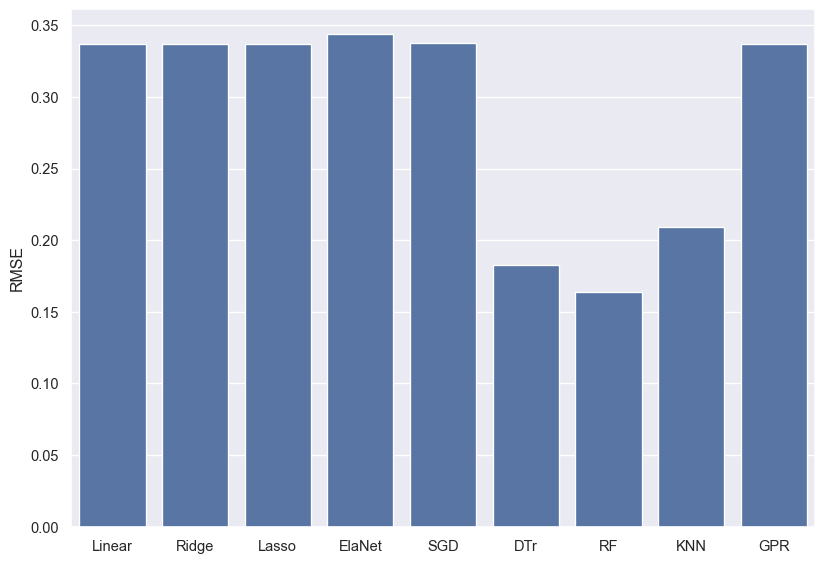

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

#### Subseção 3.12 Correlação dos resultados do modelo

Calculamos a correlação entre as previsões de diferentes modelos para
identificar modelos com previsões semelhantes.

In [94]:
predictions = {'Linear': pred_linreg_all, 'Ridge': pred_ridge_all, 'Lasso': pred_lasso,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn, 'GPR': pred_gpr}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

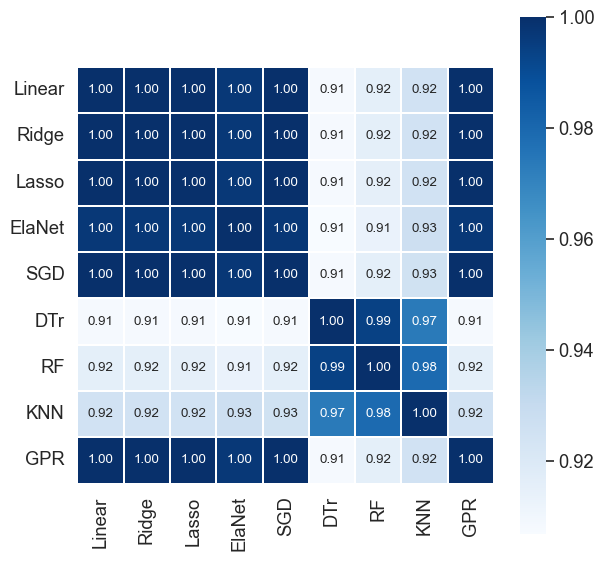

In [95]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, cmap='Blues',
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

#### Subseção 3.13 Média das previsões dos modelos

Calculamos a média das previsões de modelos selecionados para criar um
modelo de conjunto.

In [96]:
sub_mean = pd.DataFrame()
sub_mean['aluguel'] = np.round( (pred_lasso + pred_enet + pred_rf + pred_sgd) / 4.0 ) 
sub_mean['aluguel'] = sub_mean['aluguel'].astype(float)
sub_mean.to_csv('mean.csv',index=False)

# Parte 4: Conclusões

Este projeto teve como objetivo construir um modelo de Machine Learning
para prever o valor ideal de aluguel de imóveis na plataforma da Sexto
Andar. Para isso, foram analisados dados de diversos imóveis
cadastrados, considerando suas características e informações relevantes
do mercado.

A análise exploratória dos dados revelou que as variáveis “área” e
“quartos”, junto com “banheiros”, “garagem”, “iptu” e “valor total”,
apresentavam forte correlação com o valor do aluguel, sendo incluídas
nos testes de modelos desde o início. As demais variáveis, incluindo
“mobília”, apresentaram baixa correlação com o alvo e, portanto, foram
descartadas para evitar o aumento da complexidade do modelo sem ganhos
significativos de performance.

Dentre os modelos testados, o Random Forest se destacou com a menor taxa
de erro (RMSE), seguido de perto por Decision Tree e KNN. Os demais
algoritmos (Linear, Ridge, Lasso, ElasticNet, SGD e GPR) apresentaram
resultados muito similares entre si, porém inferiores aos três
primeiros.

É importante ressaltar que a decisão de descartar variáveis com baixa
correlação, como “mobília”, foi baseada em testes e análises
estatísticas. A inclusão dessas variáveis em novos testes não traria
ganhos significativos de performance, inviabilizando o custo
computacional adicional. Pelo contrário, a tendência seria a de “sujar”
o modelo com informações pouco relevantes.

Em suma, o modelo Random Forest, utilizando não só as variáveis “área” e
“quartos”, mas também as “banheiros”, “garagem”, “iptu” e “valor total”,
mostrou-se como a solução mais precisa para a previsão do valor de
aluguel, otimizando o processo de definição de preços na plataforma da
Sexto Andar.